# Sequential DIC results viewer

Interactive notebook to visualize the fields stored in a `fields_sequence.npz` file.
It uses `d2ic.DICPlotter` to overlay U1/U2/E11/E22/E12/Discrepancy on top of the deformed images.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from pathlib import Path

from d2ic import DICPlotter, DICResult, DICDiagnostics
from d2ic.mesh_assets import Mesh
from d2ic.pixel_assets import build_pixel_assets

try:
    import imageio.v2 as imageio
except Exception:
    imageio = None

try:
    import tifffile
except Exception:
    tifffile = None

try:
    import matplotlib.image as mpl_image
except Exception:
    mpl_image = None

try:
    import meshio
except Exception as exc:
    meshio = None
    print(f'meshio not available: {exc}')


## Configuration
- `NPZ_PATH`: output generated by the sequential pipeline (default: `doc/_outputs/sequence_platehole/fields_sequence.npz`).
- `MESH_PATH`: mesh file used during the run (optional but recommended).


In [2]:
# Update these paths if needed.
NPZ_PATH = Path('.') / '_outputs' / 'sequence_platehole' / 'fields_sequence.npz'
MESH_PATH = None  # e.g. Path('doc') / 'roi_mesh.msh'


In [3]:
def _imread_gray(path: Path) -> np.ndarray:
    for loader in (_try_imageio, _try_tifffile, _try_matplotlib):
        arr = loader(path)
        if arr is None:
            continue
        data = np.asarray(arr)
        if data.ndim == 3:
            if data.shape[2] == 4:
                data = data[..., :3]
            data = data.mean(axis=2)
        return data.astype(np.float32, copy=False)
    raise RuntimeError(f'Could not read image {path} with the available backends.')

def _try_imageio(path: Path):
    if imageio is None:
        return None
    try:
        return imageio.imread(path)
    except Exception:
        return None

def _try_tifffile(path: Path):
    if tifffile is None:
        return None
    try:
        return tifffile.imread(path)
    except Exception:
        return None

def _try_matplotlib(path: Path):
    if mpl_image is None:
        return None
    try:
        return mpl_image.imread(path)
    except Exception:
        return None


In [4]:
def _load_mesh(mesh_path: Path) -> Mesh:
    if meshio is None:
        raise RuntimeError('meshio is required to read .msh files')
    msh = meshio.read(str(mesh_path), file_format='gmsh')
    cells = msh.cells_dict
    if 'quad' in cells:
        elements = cells['quad']
    elif 'triangle' in cells:
        elements = cells['triangle']
    else:
        raise ValueError(f'Unsupported cell types in mesh: {list(cells)}')
    nodes_xy = msh.points[:, :2]
    return Mesh(nodes_xy=nodes_xy, elements=elements.astype(np.int32))

def _guess_mesh_path(npz_path: Path) -> Path | None:
    candidates = [
        npz_path.parent / 'roi_mesh.msh',
        Path('doc') / 'roi_mesh.msh',
        Path('roi_mesh.msh'),
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

def _find_matching_mesh(npz_path: Path, n_nodes: int) -> Path | None:
    if meshio is None:
        return None
    search_dirs = [npz_path.parent, Path('doc'), Path('.') ]
    seen = set()
    for d in search_dirs:
        if not d.exists():
            continue
        for mesh_path in d.glob('*.msh'):
            if mesh_path in seen:
                continue
            seen.add(mesh_path)
            try:
                msh = meshio.read(str(mesh_path), file_format='gmsh')
            except Exception:
                continue
            if msh.points.shape[0] == n_nodes:
                return mesh_path
    return None


In [5]:
npz_path = NPZ_PATH
if not npz_path.exists():
    raise FileNotFoundError(f'NPZ file not found: {npz_path}')

data = np.load(npz_path, allow_pickle=True)
u_all = data['u_nodal']
strain_all = data['strain']
nodes_xy = data['nodes_xy']
discrepancy_ref_all = data['discrepancy_ref'] if 'discrepancy_ref' in data else None

ref_path = Path(str(data['ref_path'])) if 'ref_path' in data else None
def_paths = [Path(p) for p in data['def_paths']] if 'def_paths' in data else []

print('Loaded NPZ:', npz_path)
print('u_nodal:', u_all.shape)
print('strain:', strain_all.shape)
if discrepancy_ref_all is not None:
    print('discrepancy_ref:', discrepancy_ref_all.shape)
print('frames:', len(def_paths))


Loaded NPZ: _outputs/sequence_platehole/fields_sequence.npz
u_nodal: (11, 3065, 2)
strain: (11, 3065, 3)
discrepancy_ref: (11, 1040, 400)
frames: 11


In [6]:
mesh_path = MESH_PATH or _guess_mesh_path(npz_path)
if mesh_path is None:
    mesh_path = _find_matching_mesh(npz_path, u_all.shape[1])
if mesh_path is None:
    raise FileNotFoundError('Mesh file not found. Set MESH_PATH to your .msh file.')

mesh = _load_mesh(mesh_path)
if mesh.nodes_xy.shape[0] != u_all.shape[1]:
    alt_path = _find_matching_mesh(npz_path, u_all.shape[1])
    if alt_path is not None and alt_path != mesh_path:
        mesh_path = alt_path
        mesh = _load_mesh(mesh_path)

if mesh.nodes_xy.shape[0] != u_all.shape[1]:
    raise ValueError(
        f'Mesh nodes ({mesh.nodes_xy.shape[0]}) do not match u_nodal ({u_all.shape[1]}). '
        'Set MESH_PATH to the exact mesh used for the DIC run.'
    )

print('Mesh:', mesh_path, 'nodes:', mesh.nodes_xy.shape, 'elements:', mesh.elements.shape)

ref_image = _imread_gray(ref_path) if ref_path else None
def_images = [_imread_gray(p) for p in def_paths]

pixel_ref = ref_image
if pixel_ref is None:
    if not def_images:
        raise RuntimeError('Cannot build pixel assets without either a reference image or deformed frames.')
    pixel_ref = def_images[0]
pixel_assets = build_pixel_assets(mesh=mesh, ref_image=pixel_ref, binning=1.0)


Mesh: _outputs/sequence_platehole/roi_mesh.msh nodes: (3065, 2) elements: (1499, 4)


## Interactive viewer
Choose a frame and a field (U1/U2/E11/E22/E12/Discrepancy).


Output()

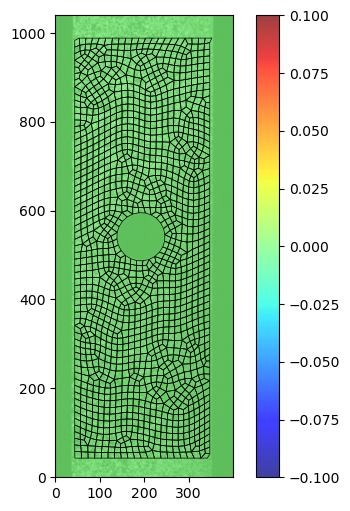

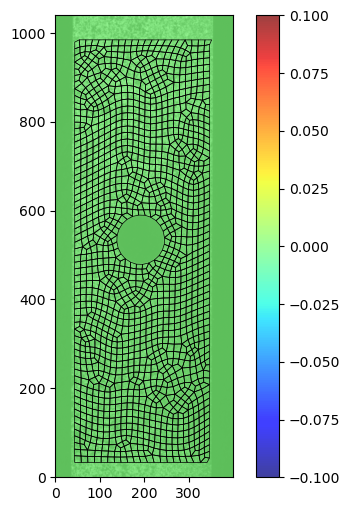

In [7]:
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max(0, len(def_images) - 1),
    step=1,
    description='Frame',
)

field_options = [('U1', 'u1'), ('U2', 'u2'), ('E11', 'e11'), ('E22', 'e22'), ('E12', 'e12')]
if ref_image is not None:
    field_options.append(('Discrepancy', 'discrepancy'))
if discrepancy_ref_all is not None:
    field_options.append(('Discrepancy (ref map)', 'discrepancy_ref'))
field_dropdown = widgets.Dropdown(
    options=field_options,
    value='u1',
    description='Field',
)
alpha_slider = widgets.FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='Alpha')
plot_mesh = widgets.Checkbox(value=True, description='Show mesh')
projection_mode = widgets.Dropdown(
    options=[('Deformed (fast)', 'fast'), ('Deformed (exact)', True), ('Reference', False)],
    value='fast',
    description='Projection',
)
out = widgets.Output()

def _update(*_):
    idx = int(frame_slider.value)
    field = field_dropdown.value
    with out:
        clear_output(wait=True)
        if field == 'discrepancy_ref':
            fig, ax = plt.subplots(figsize=(6.0, 6.0))
            ax.imshow(def_images[idx], cmap='gray', origin='lower', alpha=1.0)
            overlay = np.ma.array(discrepancy_ref_all[idx], mask=~np.isfinite(discrepancy_ref_all[idx]))
            ax.imshow(overlay, cmap='jet', origin='lower', alpha=alpha_slider.value)
            ax.set_title('Discrepancy (ref map)')
            ax.set_aspect('equal')
            plt.show()
            return
        result = DICResult(
            u_nodal=u_all[idx],
            strain=strain_all[idx],
            diagnostics=DICDiagnostics(info={'source': 'npz'}),
        )
        plotter = DICPlotter(
            result=result,
            mesh=mesh,
            def_image=def_images[idx],
            ref_image=ref_image,
            binning=1.0,
            pixel_assets=pixel_assets,
            project_on_deformed=projection_mode.value,
        )
        plotter.plot(field=field, image_alpha=alpha_slider.value, cmap='jet', plotmesh=plot_mesh.value)
        plt.show()

for w in (frame_slider, field_dropdown, alpha_slider, plot_mesh, projection_mode):
    w.observe(_update, names='value')

display(widgets.HBox([frame_slider, field_dropdown, alpha_slider, plot_mesh, projection_mode]))
display(out)
_update()
